# ConvSCCS cross validation on simulated longitudinal features example

In this example we simulate longitudinal data with preset relative incidence for each feature as done in the simulations analysis presented in the paper.
We then perform a cross validation of the ConvSCCS model and compare the estimated coefficients to the relative incidences used for the simulation.

This notebook uses the [Tick](https://x-datainitiative.github.io/tick) library, containing our implementation of ConvSCCS. Tick can be installed with `pip install tick`

## 1. Data simulation

In [1]:
%matplotlib inline

import numpy as np
from scipy.sparse import csr_matrix, hstack
from matplotlib import cm
import matplotlib.pylab as plt
import tick
from tick.survival.simu_sccs import CustomEffects
from tick.survival import SimuSCCS, ConvSCCS
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
warnings.filterwarnings("ignore")

# print(tick.__version__)  # release v. 0.5.0

In [2]:
# Simulation parameters
seed = 42
lags = 49
n_samples = 4000
n_intervals = 750
n_corr = 14

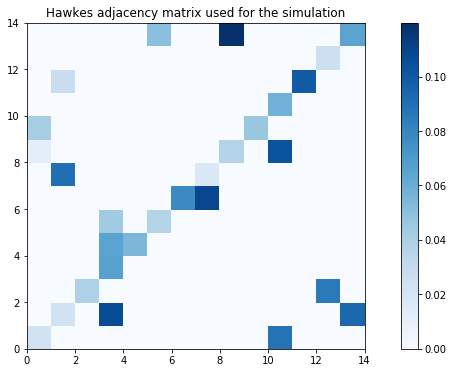

In [3]:
# Relative incidence functions used for the simulation
ce = CustomEffects(lags + 1)
null_effect = [ce.constant_effect(1)] * 7
constant_effect = ce.constant_effect(1.5)
early_effect = ce.bell_shaped_effect(2, 20)
intermediate_effect = ce.bell_shaped_effect(2, 30, 15, 15)
late_effects = [ce.increasing_effect(2, curvature_type=1)[::-1],
                ce.increasing_effect(2, curvature_type=1),
                ce.increasing_effect(2, curvature_type=2),
                ce.increasing_effect(2, curvature_type=4)]

sim_effects = [*null_effect, constant_effect, early_effect, intermediate_effect, *late_effects]

## To use the other set of risk curves presented in the paper, use the following code
# from effects import Effects
# e = Effects(n_lags + 1)
# sim_effects = [e.yonas_1(), e.yonas_2(), e.yonas_3(), e.yonas_4()]

n_features = len(sim_effects)
n_lags = np.repeat(lags, n_features).astype('uint64')

coeffs = [np.log(c) for c in sim_effects]

# Time drift (age effect) used for the simulations.
time_drift = lambda t: np.log(8 * np.sin(.01 * t) + 9)

# Simaltion of the features.
sim = SimuSCCS(n_samples, n_intervals, n_features, n_lags,
               time_drift=time_drift, coeffs=coeffs, seed=seed,
               n_correlations=n_corr, verbose=False)
features, censored_features, labels, censoring, coeffs = sim.simulate()

# Plot the Hawkes kernel matrix used to generate the features.
fig, ax = plt.subplots(figsize=(7, 6))
heatmap = ax.pcolor(sim.hawkes_exp_kernels.adjacency, cmap=cm.Blues)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
fig.colorbar(heatmap, cax=cax)
ax.set_title('Hawkes adjacency matrix used for the simulation')
plt.show()

In [4]:
## Add age_groups features to feature matrices.
agegrps = [0, 125, 250, 375, 500, 625, 750]
n_agegrps = len(agegrps) - 1

feat_agegrp = np.zeros((n_intervals, n_agegrps))
for i in range(n_agegrps):
    feat_agegrp[agegrps[i]:agegrps[i + 1], i] = 1

feat_agegrp = csr_matrix(feat_agegrp)
features = [hstack([f, feat_agegrp]).tocsr() for f in features]
censored_features = [
    hstack([f, feat_agegrp]).tocsr() for f in censored_features
]
n_lags = np.hstack([n_lags, np.zeros(n_agegrps)])

## 2. Cross-validation

Best model hyper parameters: 

C_tv : 635.835886 

C_group_l1 : 13311.216081 



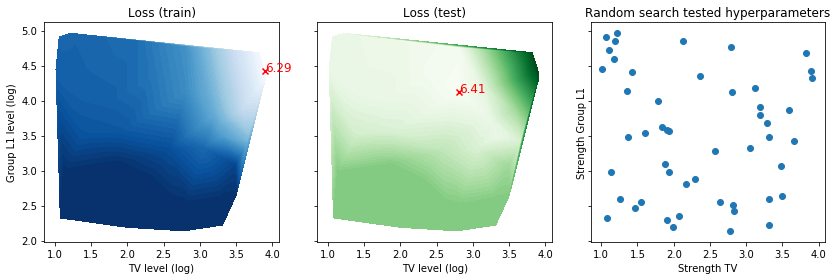

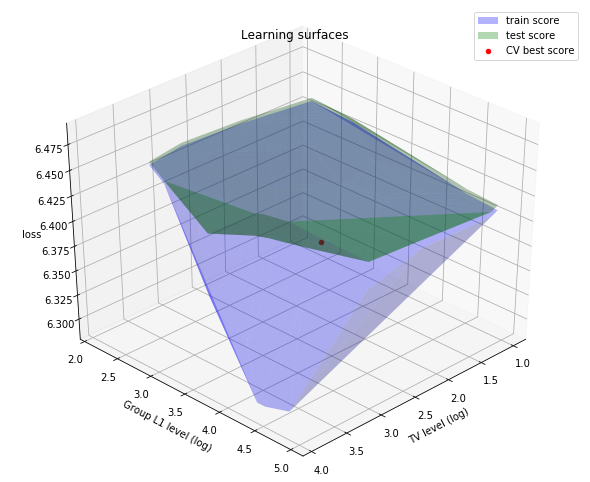

In [5]:
# Learning
# Cross-validation to select bect hyperparameters
learner = ConvSCCS(n_lags=n_lags.astype('uint64'),
                   penalized_features=np.arange(n_features),
                   random_state=seed)
C_TV_range = (1, 4)
C_L1_range = (2, 5)
_, cv_track = learner.fit_kfold_cv(features, labels, censoring,
                                   C_TV_range, C_L1_range,
                                   confidence_intervals=True,
                                   n_samples_bootstrap=20, n_cv_iter=50)
print("Best model hyper parameters: \n")
print("C_tv : %f \n" % cv_track.best_model['C_tv'])
print("C_group_l1 : %f \n" % cv_track.best_model['C_group_l1'])
cv_track.plot_cv_report(35, 45)
plt.show()
confidence_intervals = cv_track.best_model['confidence_intervals']

In [6]:
print(" Best parameters:\n", "----------------\n",
      *["\t {k}: {v} \n".format(k=k, v=v) for k, v in cv_track.find_best_params().items()])

 Best parameters:
 ----------------
 	 C_tv: 635.8358856676252 
 	 C_group_l1: 13311.216080736887 



## Results

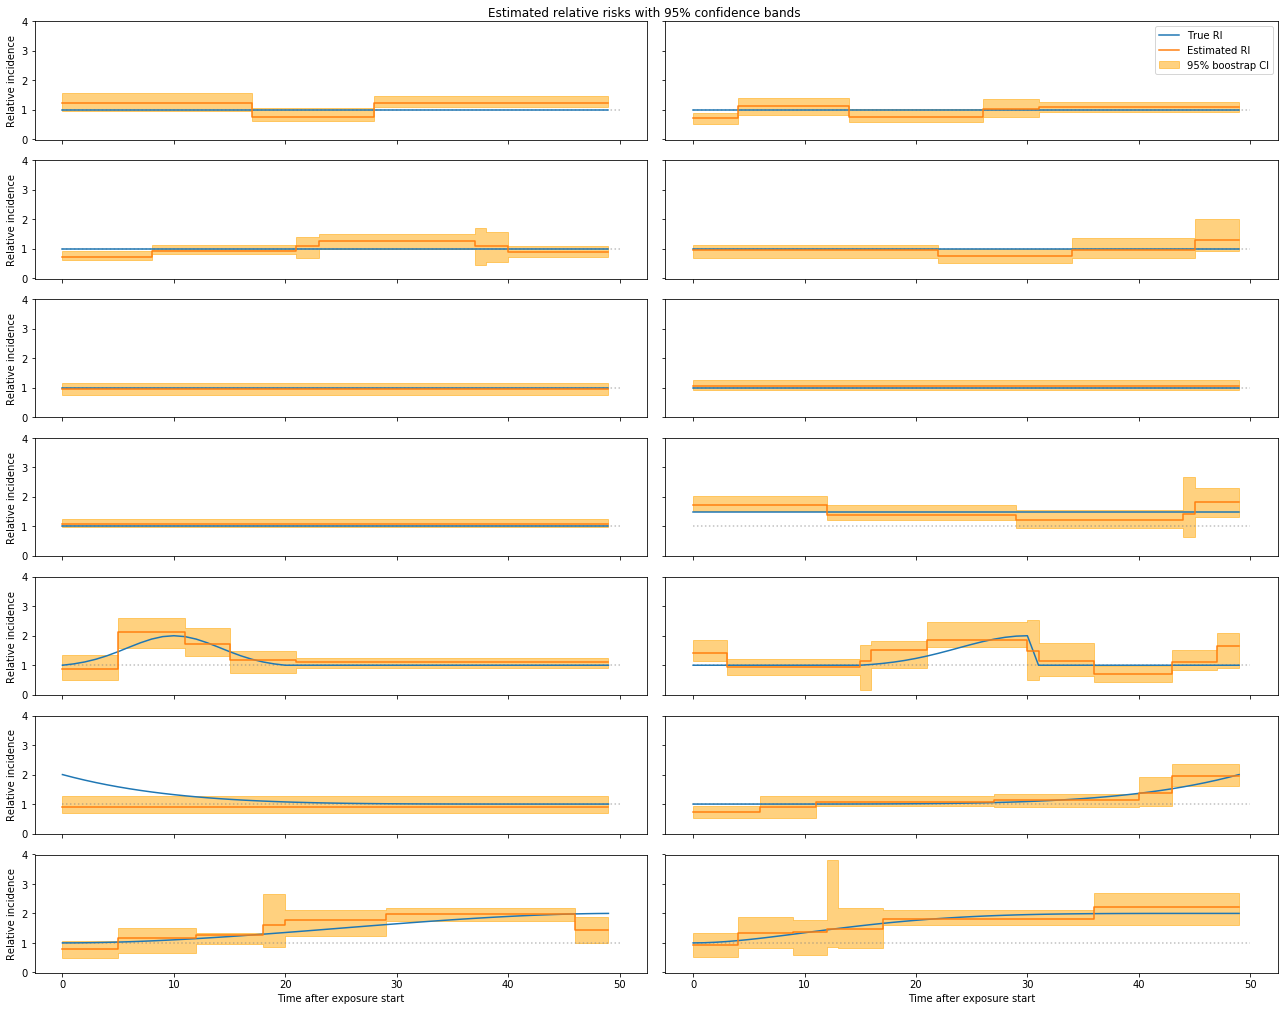

In [7]:
# Plot estimated parameters with bootstrap confidence intervals
refitted_coeffs = confidence_intervals['refit_coeffs']
lower_bound = confidence_intervals['lower_bound']
upper_bound = confidence_intervals['upper_bound']

n_rows = int(np.ceil(n_features / 2))
remove_last_plot = (n_features % 2 != 0)

fig, axarr = plt.subplots(n_rows, 2, sharex=True, sharey=True, figsize=(18, 14))
y = confidence_intervals['refit_coeffs']
lb = confidence_intervals['lower_bound']
ub = confidence_intervals['upper_bound']
for i, c in enumerate(y[:n_features]):
    ax = axarr[i // 2][i % 2]
    l = n_lags[i]
    ax.plot(np.exp(coeffs[i]), label="True RI")
    ax.step(np.arange(l + 1), np.exp(c), label="Estimated RI")
    ax.fill_between(
        np.arange(l + 1), np.exp(lb[i]), np.exp(ub[i]), alpha=.5,
        color='orange', step='pre', label="95% boostrap CI")
    ax.hlines(1, 0, lags+1, linestyles=':', color='gray', alpha=.5)
axarr[0][1].legend(loc='best')
[ax[0].set_ylabel('Relative incidence') for ax in axarr]
[ax.set_xlabel('Time after exposure start') for ax in axarr[-1]]
plt.tight_layout()
plt.suptitle('Estimated relative risks with 95% confidence bands', y=1)
if remove_last_plot:
    fig.delaxes(axarr[-1][-1])
plt.show()

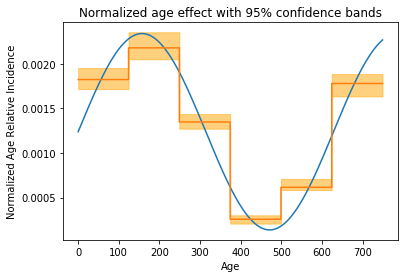

In [8]:
normalize = lambda x: x / np.sum(x)
m = np.repeat(np.hstack(refitted_coeffs[-n_agegrps:]), 125)
lb = np.repeat(np.hstack(lower_bound[-n_agegrps:]), 125)
ub = np.repeat(np.hstack(upper_bound[-n_agegrps:]), 125)
plt.figure()
plt.plot(
    np.arange(n_intervals),
    normalize(np.exp(time_drift(np.arange(n_intervals)))))
plt.step(np.arange(n_intervals), normalize(np.exp(m)))
plt.fill_between(
    np.arange(n_intervals),
    np.exp(lb) / np.exp(m).sum(),
    np.exp(ub) / np.exp(m).sum(), alpha=.5, color='orange', step='pre')
plt.xlabel('Age')
plt.ylabel('Normalized Age Relative Incidence')
plt.title("Normalized age effect with 95% confidence bands")
plt.show()

In [9]:
def absolute_error(coeffs, estimates):
    theta = coeffs.ravel()
    se = np.sum(np.abs(theta - estimates.ravel()))
    return se

def mae(coeffs, estimates):
    n = len(coeffs)
    return absolute_error(coeffs, estimates) / n

In [10]:
offset = int(n_lags[:n_features].sum() + n_features)
estimated_coeffs = cv_track.best_model['_coeffs']
print("MAE (drug exposures): ",
      mae(np.array(estimated_coeffs[:offset]), np.hstack(coeffs[:n_features])))

normalized_time_drift = normalize(np.exp(time_drift(np.arange(750))))
normalized_age_effect = normalize(np.exp(np.repeat(np.array(estimated_coeffs[offset:]), 125)))

print("MAE (time drift): ",
      mae(normalized_time_drift, normalized_age_effect))

MAE (drug exposures):  0.17790315414447527
MAE (time drift):  0.0002387846776955315
